In [3]:
!pip install pandas
!pip install yfinance
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import plotly.graph_objects as go
from datetime import datetime

# Obtento dados OHLC (High and Low on candles)

[*********************100%***********************]  1 of 1 completed


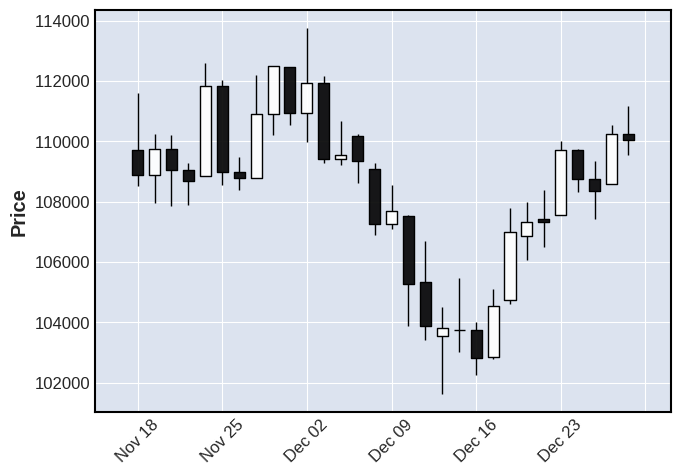

In [5]:
# Pegando dados do IBOV
df = yf.download('^BVSP', start='2022-01-01', end='2023-01-01')
mpf.plot(df[-30:], type='candle')


# Construindo as funções

Retomando os dados diários do IBOV em 2022 e checar o candle do dia 27/12, que é um fundo segundo metodologia para 2 candles.

Atentar para o candle de referência atende às duas regras:



1.   Mínima (candle referência) é menor que a dos dois candles anteriores
2.   Mínima (candle referência) é menor que d dos dois candles posteriores



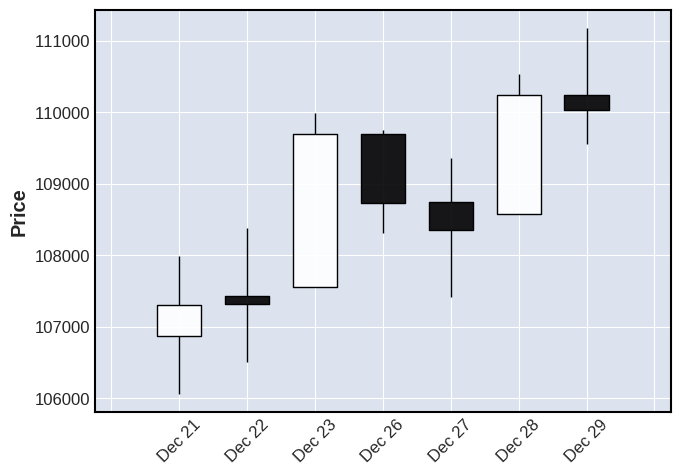

In [6]:
# Filtrando apenas os últimos 7 candles, para análise

mpf.plot(df[-7:], type="candle")

Fundo será quando a minha mínima for menor que alguns candles para trás e para frente.

Só saberemos que é um fundo quando o preço se deslocou para frente.

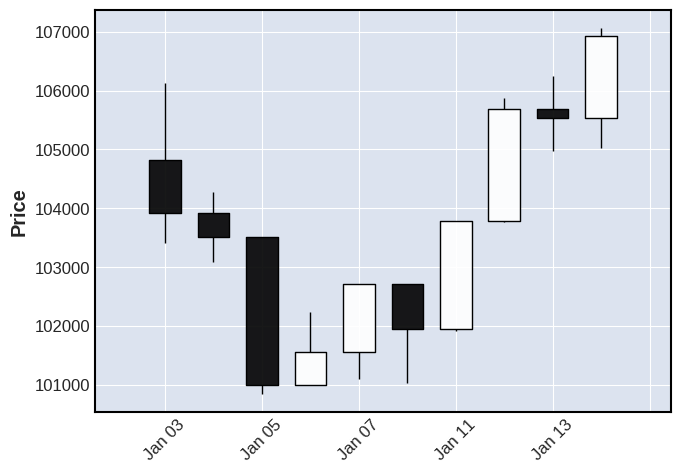

In [7]:
# Filtrando apenas os candles posteriores, para análise

mpf.plot(df[:10], type="candle")

In [8]:
# Função para testar se a minha mínima é menor ou igual a mínima dos 2 candles anteriores.
# a função rolling inclui a própria linha, então estamos usando o "closed=left", para não incluir o valor da própria linha
# sem o "=" ele não irá detectar fundos duplos. (Fundos duplos são dois candles com mínimas iguais)

df['Low'] <= df['Low'].rolling(2, closed='left').min()

Date
2022-01-03    False
2022-01-04    False
2022-01-05     True
2022-01-06    False
2022-01-07    False
              ...  
2022-12-23    False
2022-12-26    False
2022-12-27     True
2022-12-28    False
2022-12-29    False
Name: Low, Length: 250, dtype: bool

O retorno é um booleando (true or false) indicando se a condição passada é atendida.

In [9]:
# Acessando linhas posteriores e trazendo as mínimas
# Com o iloc está invertendo o dataframe, acessando os últimos dados 

df_invertido = df.iloc[::-1]
df_invertido.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-29,110237.0,111178.0,109560.0,110031.0,110031.0,13389100
2022-12-28,108578.0,110536.0,108578.0,110237.0,110237.0,11193900
2022-12-27,108739.0,109353.0,107418.0,108347.0,108347.0,11158100
2022-12-26,109699.0,109755.0,108309.0,108738.0,108738.0,5219500
2022-12-23,107552.0,109994.0,107552.0,109698.0,109698.0,12847100


In [10]:
# Acessando linhas posteriores e trazendo as mínimas (no dataframe invertido)

df_invertido = df.iloc[::-1]
df_invertido['Low'] <= df_invertido['Low'].rolling(2, closed='left').min()

Date
2022-12-29    False
2022-12-28    False
2022-12-27     True
2022-12-26    False
2022-12-23    False
              ...  
2022-01-07    False
2022-01-06     True
2022-01-05     True
2022-01-04    False
2022-01-03    False
Name: Low, Length: 250, dtype: bool

In [11]:
# Criando funções para localizar fundos

def localizar_fundos(df, n_candles=2):

  df_invertido = df.iloc[::-1]

  cond_low_anteriores  = df['Low'] <= df['Low'].rolling(n_candles, closed='left').min()
  cond_low_posteriores = df_invertido['Low'] <= df_invertido['Low'].rolling(n_candles, closed='left').min()

  return (cond_low_anteriores & cond_low_posteriores)

o return vai trazer um booleando validando se as duas condições forem verdadeiras ele trará um "TRUE" ou se apenas uma das condições forem verdadeira, ele trará um "FALSE"

In [12]:
# Executando a função criada acima

localizar_fundos(df)

Date
2022-01-03    False
2022-01-04    False
2022-01-05     True
2022-01-06    False
2022-01-07    False
              ...  
2022-12-23    False
2022-12-26    False
2022-12-27     True
2022-12-28    False
2022-12-29    False
Name: Low, Length: 250, dtype: bool

In [13]:
# Criando funções para localizar topos

def localizar_topos(df, n_candles=2):

  df_invertido = df.iloc[::-1]

  cond_high_anteriores  = df['High'] >= df['High'].rolling(n_candles, closed='left').min()
  cond_high_posteriores = df_invertido['High'] >= df_invertido['High'].rolling(n_candles, closed='left').min()

  return (cond_high_anteriores & cond_high_posteriores)

In [14]:
# Executando a função criada acima

localizar_topos(df)

Date
2022-01-03    False
2022-01-04    False
2022-01-05    False
2022-01-06    False
2022-01-07     True
              ...  
2022-12-23     True
2022-12-26     True
2022-12-27    False
2022-12-28    False
2022-12-29    False
Name: High, Length: 250, dtype: bool

In [15]:
# Lógica de Programação
# Detectar os topos e fundos em cada linha do Data Frame e armazenar os dados

n_candles = 2

# Criando um dicionário para armazenar os dados de vertice, data e preço
dict_topos_fundos = {'vertice':[], 'data':[], 'preco':[]}

# No for como não passamos o parâmetro ele irá percorrer todas as linhas do df
for i in range (len(df)):  

  if localizar_fundos(df, n_candles).iloc[i]:
     dict_topos_fundos['vertice'].append('fundo')
     dict_topos_fundos['data'].append(df.index[i])
     dict_topos_fundos['preco'].append(df.Low.iloc[i])

  if localizar_topos(df, n_candles).iloc[i]:
     dict_topos_fundos['vertice'].append('topo')
     dict_topos_fundos['data'].append(df.index[i])
     dict_topos_fundos['preco'].append(df.High.iloc[i])

In [16]:
# Transformando o Dicionário em um Data Frame

df_topos_fundos = pd.DataFrame(dict_topos_fundos)
df_topos_fundos.index = df_topos_fundos.data
df_topos_fundos.head(10)

,vertice,data,preco
data,,,
2022-01-05,fundo,2022-01-05,100850.0
2022-01-07,topo,2022-01-07,102719.0
2022-01-14,topo,2022-01-14,107062.0
2022-01-20,topo,2022-01-20,109873.0
2022-01-21,topo,2022-01-21,109786.0
2022-01-24,fundo,2022-01-24,106624.0
2022-01-27,topo,2022-01-27,113057.0
2022-01-28,topo,2022-01-28,112969.0
2022-01-31,fundo,2022-01-31,111195.0


In [17]:
# Juntando o Data Frame criado acima com o Data Frame de dados importado do Yahoo Finance com as cotações do IBOV

df_final = pd.merge(df, df_topos_fundos, left_index=True, right_index=True, how='left')
df_final.head(10)

,Open,High,Low,Close,Adj Close,Volume,vertice,data,preco
Date,,,,,,,,,
2022-01-03,104823.0,106125.0,103413.0,103922.0,103922.0,11128500,NaN,NaT,NaN
2022-01-04,103922.0,104276.0,103096.0,103514.0,103514.0,11491600,NaN,NaT,NaN
2022-01-05,103514.0,103514.0,100850.0,101006.0,101006.0,0,fundo,2022-01-05,100850.0
2022-01-06,101006.0,102235.0,101000.0,101561.0,101561.0,11749200,NaN,NaT,NaN
2022-01-07,101561.0,102719.0,101104.0,102719.0,102719.0,11733200,topo,2022-01-07,102719.0
2022-01-10,102719.0,102719.0,101038.0,101945.0,101945.0,10264700,NaN,NaT,NaN
2022-01-11,101946.0,103780.0,101918.0,103779.0,103779.0,12421500,NaN,NaT,NaN
2022-01-12,103779.0,105869.0,103771.0,105686.0,105686.0,13026500,NaN,NaT,NaN
2022-01-13,105686.0,106251.0,104974.0,105530.0,105530.0,11712300,NaN,NaT,NaN


In [18]:

df_figure = df_final

# Linhas para gerar os candles sticks
fig_topos_fundos = go.Figure(data=[go.Candlestick(name='', x=df_figure.index, open=df_figure.Open, high=df_figure.High,
                                            low=df_figure.Low, close=df_figure.Close, increasing_line_color='green', 
                                            decreasing_line_color='red', showlegend=False)])

# Linhas para gerar os topos e fundos
fig_topos_fundos.add_trace(go.Scatter(x=df_topos_fundos.data, y=df_topos_fundos.preco, mode="lines", line_width=2, line_dash="solid",
                                      line_color="black", name="Topos / Fundos", showlegend=True))

# Linhas para excluir "Sabados e Domingos" uma vez que em nosso df vem todos os dias.
fig_topos_fundos.update_xaxes(rangebreaks=[dict(bounds=["sat", "mond"])])

# Linhas para "Maquiar" o gráfico, com cor, margem, título e etc.
fig_topos_fundos.update_layout(xaxis_rangeslider_visible=False, title_text='<b>Indicador topos e fundos', template='none', 
                               margin=dict(l=75, r=75, t=75, b=75), paper_bgcolor="#f7f8fa", width=1200, height=600)



O problemas desse gráfico é que ele possui marcações de seguidas de topos e fundos.

In [19]:
# Criando condicionais para que ele dectetar se um fundo já existe, assim que ele detecta o fundo.
# Se ele decta ele substitui por esse novo que ele detectou.

n_candles = 2

# Criamos uma lista nova para adicionar os dados de últimos e guiar a estrutura de repetição.
ls_vertices = ['neutro'] 

dict_topos_fundos = {'vertice': [], 'data': [], 'preco': []}

for i in range(len(df)):

  if localizar_fundos(df, n_candles).iloc[i]:
    if ls_vertices[-1] != 'fundo':
      dict_topos_fundos['vertice'].append('fundo')
      dict_topos_fundos['data'].append(df.index[i])
      dict_topos_fundos['preco'].append(df.Low.iloc[i])
      ls_vertices.append('fundo')

    else:
      if df.Low.iloc[i] < dict_topos_fundos['preco'][-1]:
         dict_topos_fundos['data'][-1] = df.index[i]
         dict_topos_fundos['preco'][-1] = df.Low.iloc[i]

  if localizar_topos(df, n_candles).iloc[i]:
    if ls_vertices[-1] != 'topo':
      dict_topos_fundos['vertice'].append('topo')
      dict_topos_fundos['data'].append(df.index[i])
      dict_topos_fundos['preco'].append(df.Low.iloc[i])
      ls_vertices.append('topo')

    else:
      if df.High.iloc[i] < dict_topos_fundos['preco'][-1]:
         dict_topos_fundos['data'][-1] = df.index[i]
         dict_topos_fundos['preco'][-1] = df.High.iloc[i]


In [20]:
# Repetimos os mesmos passos que anteriormente

# Transformamos o Dicionario em DataFrame
df_topos_fundos = pd.DataFrame(dict_topos_fundos)
df_topos_fundos.index = df_topos_fundos.data

# Efetuamos o merge dos dados
df_final = pd.merge(df, df_topos_fundos, left_index=True, right_index=True, how='left')
df_final.head(20)

df_figure = df_final

# Linhas para gerar os candles sticks
fig_topos_fundos = go.Figure(data=[go.Candlestick(name='', x=df_figure.index, open=df_figure.Open, high=df_figure.High,
                                            low=df_figure.Low, close=df_figure.Close, increasing_line_color='green', 
                                            decreasing_line_color='red', showlegend=False)])

# Linhas para gerar os topos e fundos
fig_topos_fundos.add_trace(go.Scatter(x=df_topos_fundos.data, y=df_topos_fundos.preco, mode="lines", line_width=2, line_dash="solid",
                                      line_color="black", name="Topos / Fundos", showlegend=True))

# Linhas para excluir "Sabados e Domingos" uma vez que em nosso df vem todos os dias.
fig_topos_fundos.update_xaxes(rangebreaks=[dict(bounds=["sat", "mond"])])

# Linhas para "Maquiar" o gráfico, com cor, margem, título e etc.
fig_topos_fundos.update_layout(xaxis_rangeslider_visible=False, title_text='<b>Indicador topos e fundos', template='none', 
                               margin=dict(l=75, r=75, t=75, b=75), paper_bgcolor="#f7f8fa", width=1200, height=600)




# Teoria de Dow

A teoria se baseia na ideia de que o mercado se move em tendências primárias, secundárias e terciárias e que a análise de padrões de preços e volumes pode ajudar a identificar essas tendências e tomar decisões de negociação melhores. 

A Teoria de Dow está totalmente focada na variação dos preços e nada mais. A ideia de Charles Dow era encontrar uma maneira eficiente de acompanhar o sobe e desce das cotações para interpretar os movimentos das tendências do mercado. 

In [21]:
# Visualização de Dados Fractais - Charles Dow
df_1w = yf.download('^BVSP', start='2022-01-01', end='2023-01-01', interval='1wk')
df_1d = yf.download('^BVSP', start='2022-01-01', end='2023-01-01', interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [22]:

df = df_1w.copy()

n_candle = 10
ls_vertices = ['neutro']

dict_topos_fundos = {'vertice': [], 'data': [], 'preco': []}

for i in range(len(df)):

  if localizar_fundos(df, n_candles).iloc[i]:
    if ls_vertices[-1] != 'fundo':
      dict_topos_fundos['vertice'].append('fundo')
      dict_topos_fundos['data'].append(df.index[i])
      dict_topos_fundos['preco'].append(df.Low.iloc[i])
      ls_vertices.append('fundo')

    else:
      if df.Low.iloc[i] < dict_topos_fundos['preco'][-1]:
         dict_topos_fundos['data'][-1] = df.index[i]
         dict_topos_fundos['preco'][-1] = df.Low.iloc[i]

  if localizar_topos(df, n_candles).iloc[i]:
    if ls_vertices[-1] != 'topo':
      dict_topos_fundos['vertice'].append('topo')
      dict_topos_fundos['data'].append(df.index[i])
      dict_topos_fundos['preco'].append(df.High.iloc[i])
      ls_vertices.append('topo')

    else:
      if df.High.iloc[i] < dict_topos_fundos['preco'][-1]:
         dict_topos_fundos['data'][-1] = df.index[i]
         dict_topos_fundos['preco'][-1] = df.High.iloc[i]

  # Transformamos o Dicionario em DataFrame
  df_topos_fundos = pd.DataFrame(dict_topos_fundos)
  df_topos_fundos.index = df_topos_fundos.data

  # Efetuamos o merge dos dados
  df_final = pd.merge(df, df_topos_fundos, left_index=True, right_index=True, how='left')
  df_final.head(20)

  df_figure = df_final

  # Linhas para gerar os candles sticks
  fig_topos_fundos = go.Figure(data=[go.Candlestick(name='', x=df_figure.index, open=df_figure.Open, high=df_figure.High,
                                              low=df_figure.Low, close=df_figure.Close, increasing_line_color='green', 
                                              decreasing_line_color='red', showlegend=False)])

  # Linhas para gerar os topos e fundos
  fig_topos_fundos.add_trace(go.Scatter(x=df_topos_fundos.data, y=df_topos_fundos.preco, mode="lines", line_width=2, line_dash="solid",
                                        line_color="black", name="Topos / Fundos", showlegend=True))

  # Linhas para excluir "Sabados e Domingos" uma vez que em nosso df vem todos os dias.
  fig_topos_fundos.update_xaxes(rangebreaks=[dict(bounds=["sat", "mond"])])

  # Linhas para "Maquiar" o gráfico, com cor, margem, título e etc.
  fig_semanal = fig_topos_fundos.update_layout(xaxis_rangeslider_visible=False, title_text='<b>Indicador topos e fundos', template='none', 
                                margin=dict(l=75, r=75, t=75, b=75), paper_bgcolor="#f7f8fa", width=1200, height=600)


In [23]:
df = df_1d.copy()

n_candle = 10
ls_vertices = ['neutro']

dict_topos_fundos = {'vertice': [], 'data': [], 'preco': []}

for i in range(len(df)):

  if localizar_fundos(df, n_candles).iloc[i]:
    if ls_vertices[-1] != 'fundo':
      dict_topos_fundos['vertice'].append('fundo')
      dict_topos_fundos['data'].append(df.index[i])
      dict_topos_fundos['preco'].append(df.Low.iloc[i])
      ls_vertices.append('fundo')

    else:
      if df.Low.iloc[i] < dict_topos_fundos['preco'][-1]:
         dict_topos_fundos['data'][-1] = df.index[i]
         dict_topos_fundos['preco'][-1] = df.Low.iloc[i]

  if localizar_topos(df, n_candles).iloc[i]:
    if ls_vertices[-1] != 'topo':
      dict_topos_fundos['vertice'].append('topo')
      dict_topos_fundos['data'].append(df.index[i])
      dict_topos_fundos['preco'].append(df.High.iloc[i])
      ls_vertices.append('topo')

    else:
      if df.High.iloc[i] < dict_topos_fundos['preco'][-1]:
         dict_topos_fundos['data'][-1] = df.index[i]
         dict_topos_fundos['preco'][-1] = df.High.iloc[i]

  # Transformamos o Dicionario em DataFrame
  df_topos_fundos = pd.DataFrame(dict_topos_fundos)
  df_topos_fundos.index = df_topos_fundos.data

  # Efetuamos o merge dos dados
  df_final = pd.merge(df, df_topos_fundos, left_index=True, right_index=True, how='left')
  df_final.head(20)

  df_figure = df_final

  # Linhas para gerar os candles sticks
  fig_topos_fundos = go.Figure(data=[go.Candlestick(name='', x=df_figure.index, open=df_figure.Open, high=df_figure.High,
                                              low=df_figure.Low, close=df_figure.Close, increasing_line_color='green', 
                                              decreasing_line_color='red', showlegend=False)])

  # Linhas para gerar os topos e fundos
  fig_topos_fundos.add_trace(go.Scatter(x=df_topos_fundos.data, y=df_topos_fundos.preco, mode="lines", line_width=2, line_dash="solid",
                                        line_color="black", name="Topos / Fundos", showlegend=True))

  # Linhas para excluir "Sabados e Domingos" uma vez que em nosso df vem todos os dias.
  fig_topos_fundos.update_xaxes(rangebreaks=[dict(bounds=["sat", "mond"])])

  # Linhas para "Maquiar" o gráfico, com cor, margem, título e etc.
  fig_diario = fig_topos_fundos.update_layout(xaxis_rangeslider_visible=False, title_text='<b>Indicador topos e fundos', template='none', 
                                margin=dict(l=75, r=75, t=75, b=75), paper_bgcolor="#f7f8fa", width=1200, height=600)

In [24]:
fig_semanal

In [123]:
fig_diario

# Screening de Ativos IBOV

Vamos fazer o screening de quais ativos do IBOV estão nesse momento batendo o último topo

In [122]:
lista_tickers = ['ABEV3', 'ALPA4', 'ARZZ3', 'ASAI3', 'AZUL4', 'B3SA3', 'BBDC3', 'BBDC4', 'BBSE3',
                 'BEEF3', 'BPAC11', 'BPAN4', 'BRFS3', 'BRKM5', 'CASH3', 'CIEL3', 'CMIG4', 'CMIN3', 'EMBR3', 'GGBR4', 
                 'GOLL4', 'HAPV3', 'ITSA4', 'ITUB4', 'KLBN11', 'MGLU3', 'PETR3', 'PETR4', 'PETZ3', 'USIM5', 'WEGE3']
                

In [124]:
# Como os dados vieram da yfinance, precisamos adicioar o .SA em cada ativo
lista_tikers_yf = [x + '.SA' for x in lista_tickers]

In [126]:
lista_tikers_yf[0:10]

['ABEV3.SA',
 'ALPA4.SA',
 'ARZZ3.SA',
 'ASAI3.SA',
 'AZUL4.SA',
 'B3SA3.SA',
 'BBDC3.SA',
 'BBDC4.SA',
 'BBSE3.SA',
 'BEEF3.SA']

In [127]:
# Criando uma lista de ativos com as cotações de cada ativo

ls_close_ativos = []
indice_ativo = 0

for i in lista_tikers_yf:
    df_1d_ativo = yf.download(i, start='2022-01-01', interval='1d', auto_adjust=True)
    df_1d_ativo['Ticker'] = i
    df_1d_ativo['Indice_ativo'] = indice_ativo
    indice_ativo += 1
    ls_close_ativos.append(df_1d_ativo)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [128]:
# Enumerando a minha lista de ativos 
list(enumerate(lista_tikers_yf))

[(0, 'ABEV3.SA'),
 (1, 'ALPA4.SA'),
 (2, 'ARZZ3.SA'),
 (3, 'ASAI3.SA'),
 (4, 'AZUL4.SA'),
 (5, 'B3SA3.SA'),
 (6, 'BBDC3.SA'),
 (7, 'BBDC4.SA'),
 (8, 'BBSE3.SA'),
 (9, 'BEEF3.SA'),
 (10, 'BPAC11.SA'),
 (11, 'BPAN4.SA'),
 (12, 'BRFS3.SA'),
 (13, 'BRKM5.SA'),
 (14, 'CASH3.SA'),
 (15, 'CIEL3.SA'),
 (16, 'CMIG4.SA'),
 (17, 'CMIN3.SA'),
 (18, 'EMBR3.SA'),
 (19, 'GGBR4.SA'),
 (20, 'GOLL4.SA'),
 (21, 'HAPV3.SA'),
 (22, 'ITSA4.SA'),
 (23, 'ITUB4.SA'),
 (24, 'KLBN11.SA'),
 (25, 'MGLU3.SA'),
 (26, 'PETR3.SA'),
 (27, 'PETR4.SA'),
 (28, 'PETZ3.SA'),
 (29, 'USIM5.SA'),
 (30, 'WEGE3.SA')]

In [129]:
# Usando o número do índice para visualizar o DataFrame do ativo
ls_close_ativos[0]

,Open,High,Low,Close,Volume,Ticker,Indice_ativo
Date,,,,,,,
2022-01-03,14.648190,14.762184,14.391704,14.562695,23833600,ABEV3.SA,0
2022-01-04,14.553195,14.629191,14.287210,14.543696,16357700,ABEV3.SA,0
2022-01-05,14.486699,14.524697,14.211214,14.258712,24652000,ABEV3.SA,0
2022-01-06,14.287210,14.306209,13.926230,14.030725,20406300,ABEV3.SA,0
2022-01-07,14.059223,14.059223,13.726741,13.802736,19673600,ABEV3.SA,0
...,...,...,...,...,...,...,...
2023-05-03,14.250000,14.680000,14.130000,14.580000,34868300,ABEV3.SA,0
2023-05-04,15.200000,15.310000,14.470000,14.630000,54120800,ABEV3.SA,0
2023-05-05,14.670000,14.710000,14.300000,14.490000,25846600,ABEV3.SA,0


In [130]:
# Trabalhando com a lista de ativos

n_candles = 10

ls_ativos_topos_fundos = []

for df in ls_close_ativos:
    
    ls_vertices = ['neutro']
    dict_topos_fundos = {'vertice': [], 'data': [], 'preco': []}

    for i in range(len(df)):

      if localizar_fundos(df, n_candles).iloc[i]:
        if ls_vertices[-1] != 'fundo':
          dict_topos_fundos['vertice'].append('fundo')
          dict_topos_fundos['data'].append(df.index[i])
          dict_topos_fundos['preco'].append(df.Low.iloc[i])
          ls_vertices.append('fundo')

        else:
          if df.Low.iloc[i] < dict_topos_fundos['preco'][-1]:
            dict_topos_fundos['data'][-1] = df.index[i]
            dict_topos_fundos['preco'][-1] = df.Low.iloc[i]

      if localizar_topos(df, n_candles).iloc[i]:
        if ls_vertices[-1] != 'topo':
          dict_topos_fundos['vertice'].append('topo')
          dict_topos_fundos['data'].append(df.index[i])
          dict_topos_fundos['preco'].append(df.High.iloc[i])
          ls_vertices.append('topo')

        else:
          if df.High.iloc[i] < dict_topos_fundos['preco'][-1]:
            dict_topos_fundos['data'][-1] = df.index[i]
            dict_topos_fundos['preco'][-1] = df.High.iloc[i]

    # Transformamos o Dicionario em DataFrame
    df_topos_fundos = pd.DataFrame(dict_topos_fundos)
    df_topos_fundos.index = df_topos_fundos.data

    # Efetuamos o merge dos dados
    df_final = pd.merge(df, df_topos_fundos, left_index=True, right_index=True, how='left')
    df_final.head(20)

    ls_ativos_topos_fundos.append(df_final)


In [136]:
# Função que pega do DataFrame completo para encontrar os Topos e Fundos

def ativo_rompeu_topo(df):
    ultimo_topo = df[df.vertice == 'topo']['preco'][-1]
    distancia_topo = (ultimo_topo - df.Close[-1])/ultimo_topo*100

    if distancia_topo < 0:
       return 'rompeu topo'
    else:
       return 'nao rompeu topo'


In [137]:
# Lista os ativos que romperam ou não o topo anterior

for df in ls_ativos_topos_fundos:
    if ativo_rompeu_topo(df)=='rompeu topo':
       print(df.Ticker[0],'indice=',df.Indice_ativo[0],'rompeu topo anterior')

ABEV3.SA indice= 0 rompeu topo anterior
ALPA4.SA indice= 1 rompeu topo anterior
ARZZ3.SA indice= 2 rompeu topo anterior
AZUL4.SA indice= 4 rompeu topo anterior
B3SA3.SA indice= 5 rompeu topo anterior
BBDC3.SA indice= 6 rompeu topo anterior
BBDC4.SA indice= 7 rompeu topo anterior
BEEF3.SA indice= 9 rompeu topo anterior
BPAC11.SA indice= 10 rompeu topo anterior
BPAN4.SA indice= 11 rompeu topo anterior
BRFS3.SA indice= 12 rompeu topo anterior
BRKM5.SA indice= 13 rompeu topo anterior
CASH3.SA indice= 14 rompeu topo anterior
CIEL3.SA indice= 15 rompeu topo anterior
CMIG4.SA indice= 16 rompeu topo anterior
CMIN3.SA indice= 17 rompeu topo anterior
GOLL4.SA indice= 20 rompeu topo anterior
HAPV3.SA indice= 21 rompeu topo anterior
ITSA4.SA indice= 22 rompeu topo anterior
ITUB4.SA indice= 23 rompeu topo anterior
KLBN11.SA indice= 24 rompeu topo anterior
MGLU3.SA indice= 25 rompeu topo anterior
PETR3.SA indice= 26 rompeu topo anterior
PETR4.SA indice= 27 rompeu topo anterior
PETZ3.SA indice= 28 ro

In [138]:
# Plotando o candle graph com as informações dos ativos que romperam o topo anterior

# O [i] é o indice e podemos navegar nele basedo no indice de cada ativo
# No teste abaixo o item 5 é o ativo B3SA3
i = 0

df_figure = ls_ativos_topos_fundos[i]
df_topos_fundos = ls_ativos_topos_fundos[i][~ls_ativos_topos_fundos[i].preco.isna()]

# Linhas para gerar os candles sticks
fig_topos_fundos = go.Figure(data=[go.Candlestick(name='', x=df_figure.index, open=df_figure.Open, high=df_figure.High,
                                            low=df_figure.Low, close=df_figure.Close, increasing_line_color='green', 
                                            decreasing_line_color='red', showlegend=False)])

# Linhas para gerar os topos e fundos
fig_topos_fundos.add_trace(go.Scatter(x=df_topos_fundos.data, y=df_topos_fundos.preco, mode="lines", line_width=2, line_dash="solid",
                                      line_color="black", name="Topos / Fundos", showlegend=True))

# Linhas para excluir "Sabados e Domingos" uma vez que em nosso df vem todos os dias.
fig_topos_fundos.update_xaxes(rangebreaks=[dict(bounds=["sat", "mond"])])

# Linhas para "Maquiar" o gráfico, com cor, margem, título e etc.
fig_topos_fundos.update_layout(xaxis_rangeslider_visible=False, title_text='<b>Indicador topos e fundos', template='none', 
                              margin=dict(l=75, r=75, t=75, b=75), paper_bgcolor="#f7f8fa", width=1200, height=600)